In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import pandas as pd
sys.path.insert(0, '../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import importer
from quetzal.io import road as road_io
from syspy.spatial.spatial import nearest_geometry, nearest
import geopandas as gpd
import shapely
import fiona
fiona.supported_drivers['KML'] = 'rw'

SQLalchemy is not installed. No support for SQL output.


# roads

In [3]:
road_links, road_nodes = road_io.get_links_and_nodes(r'../../inputs/roads/road_2040_20137.geojson')
road_links['factor']=1
road_links.loc[road_links['highway']== 'residential', 'factor'] = 1.2
road_links['length'] = road_links.length * road_links['factor']

# lines

In [4]:
sm4326 = stepmodel.StepModel(epsg=3857, coordinates_unit='meter')

In [5]:
lines = gpd.read_file('../../inputs/lines/bajaj_lines.geojson')
stations = gpd.read_file(r'../../inputs/lines/bajajs_epsg4326.geojson')
#stations = stations.set_index('name')
stations = stations.drop_duplicates(subset=['name']).set_index('name')

<AxesSubplot:>

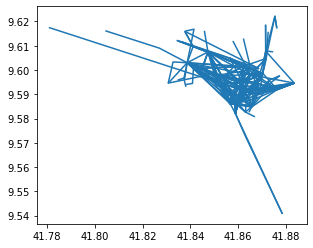

In [6]:
lines.plot()

# merge stops and routes

In [7]:
lines['route_id'] = lines.index.astype(str)
links, nodes = importer.from_lines(lines, add_return=True)
d = nearest_geometry(nodes, stations).set_index('ix_one')['ix_many'].to_dict()
nodes.index = [d[i] for i in nodes.index]
links['a'] = [d[i] for i in links['a']]
links['b'] = [d[i] for i in links['b']]
links = links.loc[links['a'] != links['b']]
nodes = stations
links = pd.merge(links, lines.drop('geometry', axis=1), on='route_id')

nearest_link: 100%|████████████████████████████████████████████████████████████| 4380/4380 [00:00<00:00, 141233.21it/s]


In [8]:
len(links)

580

# merge road and pt network 
work on projejections (CRS)

In [9]:
sm4326 = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')
sm4326.links = links
sm4326.nodes = nodes
sm20137 = sm4326.change_epsg(epsg=20137, coordinates_unit='meter')
sm20137.road_links = road_links
sm20137.road_nodes = road_nodes
sm = sm20137.copy()

Reprojecting model from epsg 4326 to epsg 20137: 100%|█████████████████████████████████| 32/32 [00:01<00:00, 16.06it/s]


In [10]:
pd.DataFrame(sm.road_nodes)

,geometry
index,
road_node_0,POINT (816118.416 1062819.265)
road_node_1,POINT (813129.238 1064418.445)
road_node_2,POINT (812547.445 1061632.711)
road_node_3,POINT (812643.135 1062721.340)
road_node_4,POINT (812275.463 1064310.885)
...,...
road_node_5439,POINT (810142.976 1063075.385)
road_node_5440,POINT (814769.878 1060139.268)
road_node_5441,POINT (812568.297 1064418.128)


# remove links that are outside of the road network

In [11]:
hull = shapely.geometry.MultiPoint(list(sm.road_nodes['geometry'])).convex_hull.buffer(1e-3)
sm.nodes = sm.nodes.loc[sm.nodes['geometry'].apply(lambda g: hull.contains(g))]

In [12]:
sm.integrity_fix_nodeset_consistency()
dump_on_demand = sm.copy()

In [13]:
sm.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=10, 
    n_neighbors=5,
    weight='length',
    penalty_factor=4,
)

40: 100%|████████████████████████████████████████████████████████████████████████████| 290/290 [00:32<00:00,  9.02it/s]


# add stops and cast network
## add stops

In [14]:
import numpy as np
def flatten(s):
    "nested iterables to iterable"
    f = []
    for l in s:
        f += l
    return f


def preparation_add_stops(self):
    
    def stop_list_to_geometry(stop_list):
        return shapely.geometry.LineString(list(self.nodes.loc[stop_list]['geometry']))
    

    
    self.analysis_lines()
    lines = self.lines.copy()
    lines.set_index('trip_id', inplace=True)
    
    flat = self.links.groupby('trip_id')['road_node_list'].agg(lambda s: flatten(list(s)))
    lines['road_node_list'] = flat
    
    # ROAD NODES TO NODES
    node_dict = self.networkcaster.road_access.reset_index('node')['node'].to_dict()
    def road_nodes_to_nodes(road_nodes):
        l = [node_dict[n] for n in road_nodes if n in node_dict]
        seen = []
        to_return = []
        for i in l:
            if i not in seen:
                to_return.append(i)
            seen.append(i)
        return to_return
    lines['nodes'] = lines['road_node_list'].apply(road_nodes_to_nodes)
    
    # STOP LIST TO GEOMETRY
    def stop_list_to_geometry(stop_list):
        return shapely.geometry.LineString(list(self.nodes.loc[stop_list]['geometry']))
    lines['geometry'] = lines['nodes'].apply(stop_list_to_geometry)
    
    links, nodes = importer.from_lines(lines, add_return=False)
    d = nearest_geometry(nodes, self.nodes).set_index('ix_one')['ix_many'].to_dict()
    links['a'] = [d[i] for i in links['a']]
    links['b'] = [d[i] for i in links['b']]
    links = links.loc[links['a'] != links['b']]
    nodes = self.nodes
    
    fix = self.copy()
    fix.nodes = nodes
    fix.links = links
    
    return fix

In [15]:
fix = preparation_add_stops(sm)
dump_fix = fix.copy()

nearest_link: 100%|██████████████████████████████████████████████████████████| 18180/18180 [00:00<00:00, 152730.63it/s]


## cast network

In [16]:
fix.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=10, 
    n_neighbors=5,
    weight='length',
    penalty_factor=4,
)

96: 100%|████████████████████████████████████████████████████████████████████████████| 290/290 [00:18<00:00, 15.87it/s]


<AxesSubplot:>

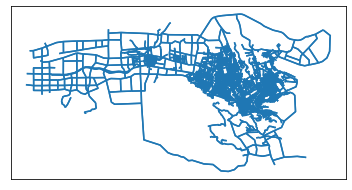

In [17]:
fix.plot('road_links')

In [18]:
fix.integrity_fix_collision(prefixes={'links':'link_'})

In [19]:
fix.integrity_test_collision(sets=['nodes', 'links', 'zones', 'road_links', 'road_nodes'])

In [20]:
fix.to_zippedpickles('../../model/base/networks')

networkcaster: 100%|███████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 21.48it/s]


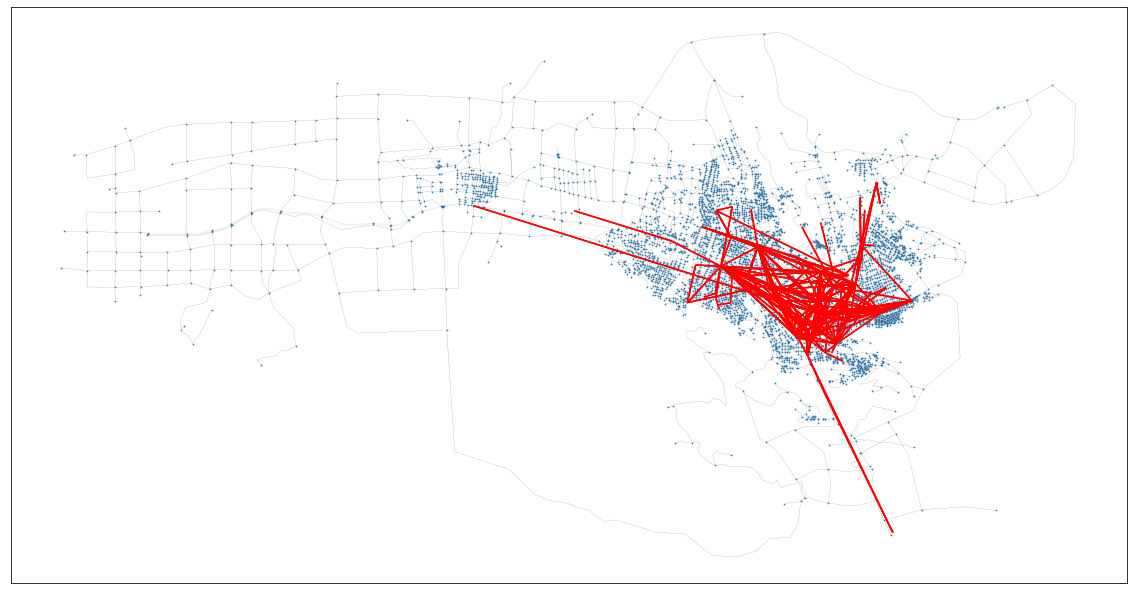

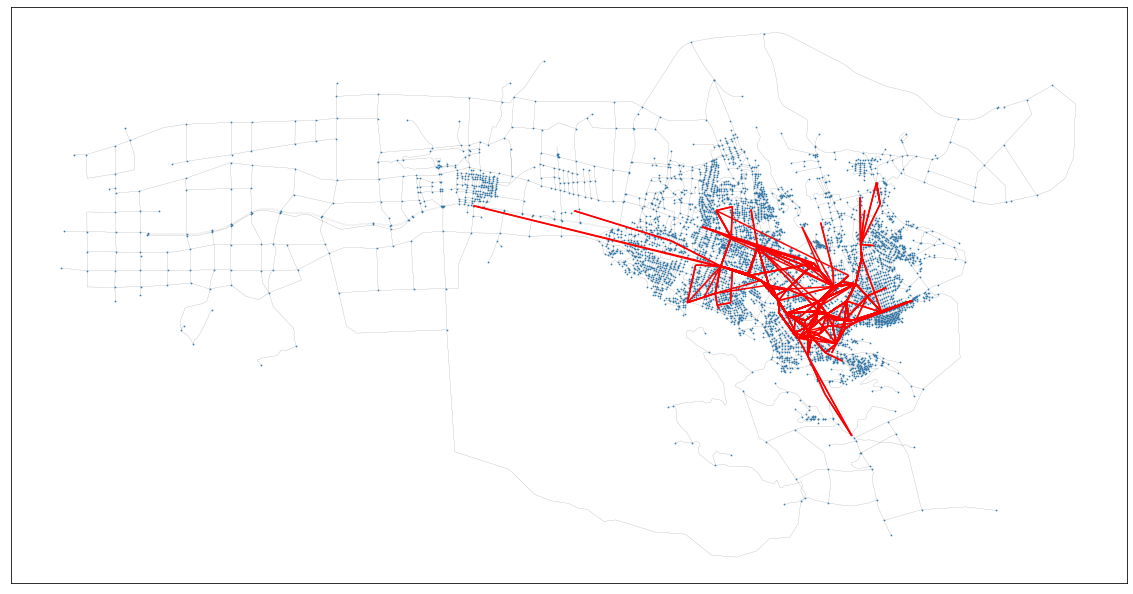

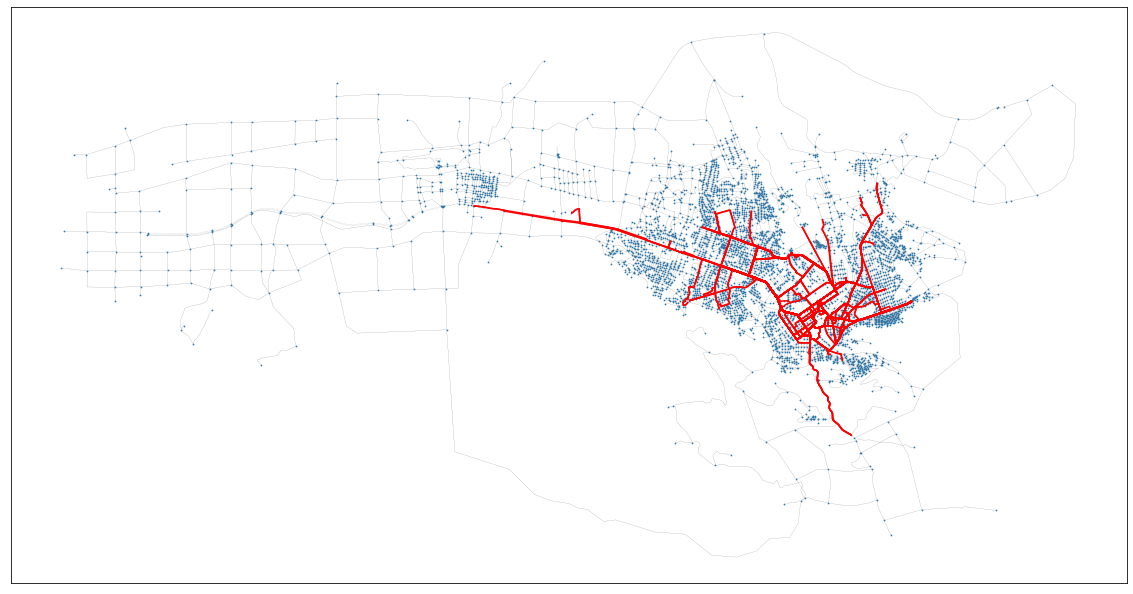

In [21]:
if manual:
    import matplotlib.pyplot as plt
    for model in dump_on_demand, dump_fix, fix:
        ax=model.plot('road_links', color='grey',linewidth=0.1, figsize=[20, 20])
        ax = model.plot('road_nodes', markersize=0.5, ax=ax)
        model.plot('links',color='red', ax=ax)
        plt.show()

Deprecated: replaced by analysis_lines


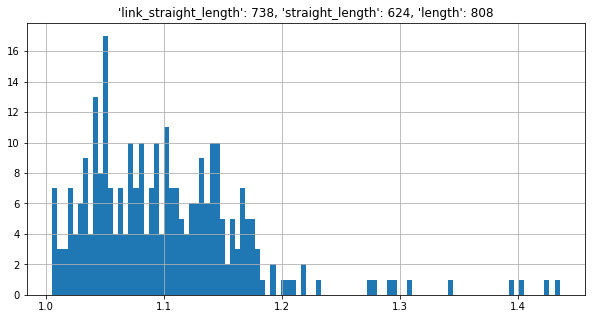

In [22]:
if manual:
    road = fix.copy()
    from shapely.geometry import LineString

    links = road.links
    links['link_straight_length'] = links['geometry'].apply(
        lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
    )
    links['length'] = links['geometry'].apply(lambda g: g.length)

    road.build_lines(force_linestring=False,sum_columns=['link_straight_length', 'length'])
    lines = road.lines
    lines['straight_length'] = lines['geometry'].apply(
        lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
    )

    lines['length_ratio'] = lines['length']/lines['link_straight_length']
    # summary
    title = str(
        (lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int).to_dict()
    )[1:-1]
    ax = lines['length_ratio'].hist(bins=100, figsize=[10, 5])
    ax.set_title(title)